<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Diego Dominguez


### **Link de repositorio de GitHub:** `https://github.com/DDominguezD/MDS7202`

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

In [1]:
# Si usted está utilizando Colabolatory le puede ser útil este código para cargar los archivos.
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = '/content/drive/MyDrive/'
except:
    print('Ignorando conexión drive-colab')

Mounted at /content/drive


In [2]:
!pip install xgboost

In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 8.5 MB/s eta 0:00:00


In [4]:
!pip install alibi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.2/524.2 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.0 MB/s eta 0:00:00


# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [5]:
import numpy as np
import pandas as pd

import shap
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

# Pre-procesamiento
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Metricas de evaluación
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import matplotlib.pyplot as plt

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [6]:
df = pd.read_csv(path+'diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


In [7]:
df.nunique()

Age                     13
Sex                      2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Stroke                   2
HighBP                   2
Diabetes                 2
dtype: int64

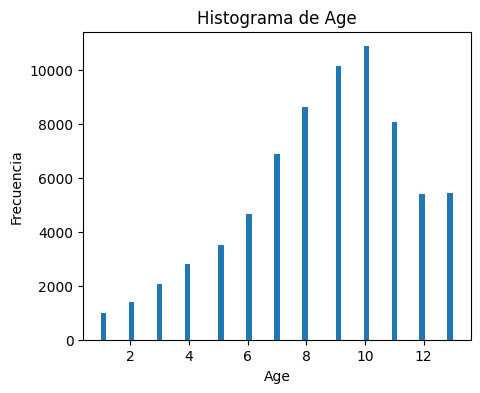

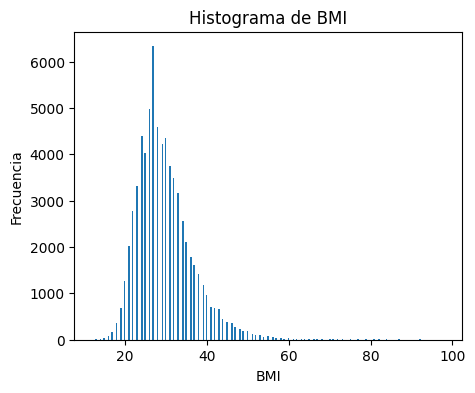

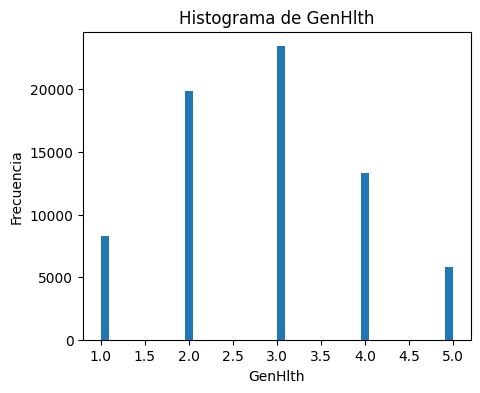

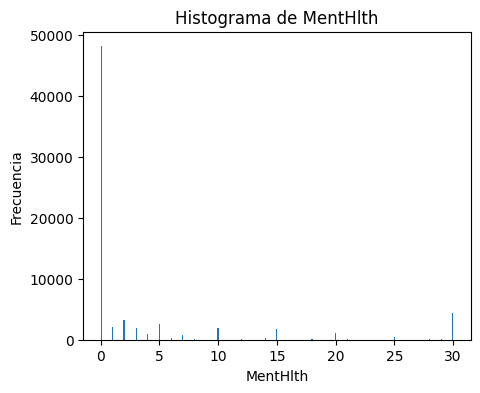

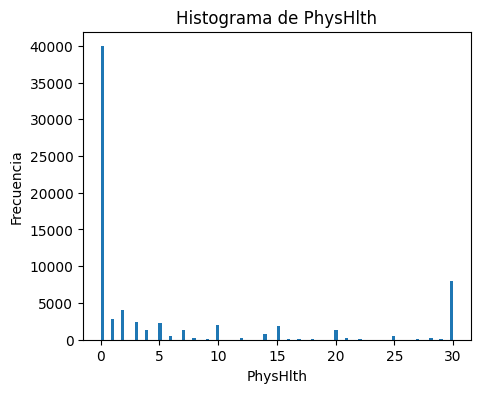

In [8]:
for columna in df.columns:
    if df[columna].nunique() > 2:
      plt.figure(figsize=(5, 4))
      plt.hist(df[columna], bins='auto')
      plt.xlabel(columna)
      plt.ylabel('Frecuencia')
      plt.title(f'Histograma de {columna}')
      plt.show()
    else:
      continue

## 2. Clasificación de pacientes con diabetes (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo una buena elección de las features?.

### Preprocesamiento

In [9]:
#Generacion de un ColumnTransformer
preprocessing_transformer = ColumnTransformer(transformers=[
    ('standardscaler', StandardScaler(), ['BMI', 'GenHlth']),
    ('minmax', MinMaxScaler(), ['Age', 'MentHlth', 'PhysHlth'])
    ],
    remainder='passthrough', verbose_feature_names_out=False)

In [10]:
# Funcion para ordenar las columnas en el pipeline
def sort_columns(data):
    sorted_data = data[df.drop(columns=['Diabetes']).columns]
    return sorted_data

In [11]:
clf = xgb.XGBClassifier(random_state=42)
pipeline = Pipeline([
    ("preprocesamiento", preprocessing_transformer),
    ('sorter', FunctionTransformer(sort_columns)),
    ("xgb", clf)
    ])

pipeline.set_output(transform="pandas")

With transform="pandas", `func` should return a DataFrame to follow the set_output API.


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['BMI', 'GenHlth']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['Age', 'MentHlth',
                                                   'PhysHlth'])],
                                   verbose_feature_names_out=False)),
                ('sorter',
                 FunctionTransformer(func=<function sort_columns at 0x7faa14a9dea0>)),
                ('xgb',
                 XGBClassifier(base_score=None,...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

Antes de realizar el preprocesamiento, se llevó a cabo un análisis inicial de la cantidad de valores únicos por columna. Esto reveló que la mayoría de las columnas tenían valores binarios. Por lo tanto, se decidió graficar un histograma para aquellas columnas que tenían una mayor diversidad de valores, con el fin de comprender mejor la distribución de los datos.

Se observó que las columnas 'BMI' y 'GenHlth' presentaban una distribución similar a la normal, por lo que se decidió aplicar un Standard Scaler. Por otro lado, aunque la columna de edad también mostraba una distribución que se asemejaba a la normal, se optó por utilizar un escalado MixMax Scaler. Esta elección permitiría obtener una medida relativa que facilitaría la comparación entre las edades, considerando su posición dentro del rango [0, 1].

Por razones similares, se decidió aplicar el mismo escalado para las columnas 'MentHlth' y 'PhysHlth', debido a su distribución de datos algo atípica.

### Entrenamiento

In [12]:
X = df.drop(columns=['Diabetes'])
y = df.loc[:, "Diabetes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, stratify=y, random_state=42)

In [13]:
pipeline.fit(X_train, y_train)

# Predecimos
y_pred = pipeline.predict(X_test)

# Evaluamos
print(classification_report(y_pred, y_test))
print(' ')

              precision    recall  f1-score   support

           0       0.70      0.77      0.73      9615
           1       0.79      0.72      0.76     11593

    accuracy                           0.75     21208
   macro avg       0.75      0.75      0.74     21208
weighted avg       0.75      0.75      0.75     21208

 


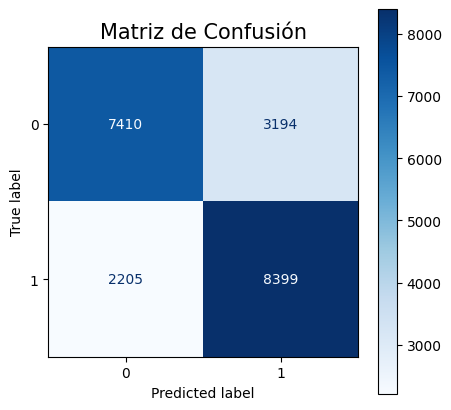

In [14]:
#Creación de la matriz de confusión
cm = confusion_matrix(y_test, y_pred) #, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# Ajuste de tamaño
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Matriz de Confusión', fontsize=15);

La precisión se centra en minimizar los falsos positivos, el recall se centra en minimizar los falsos negativos, y el F1-score proporciona una medida equilibrada de ambos aspectos.

 Una alta precisión es importante para evitar diagnosticar erróneamente a alguien como diabético cuando no lo es. Mientras que un alto recall indica que el modelo es capaz de identificar correctamente a la mayoría de los casos positivos de diabetes, minimizando así los falsos negativos y asegurando un diagnóstico oportuno y adecuado.

El recall promedio obtenido es de $0.75$, lo cual puede considerarse relativamente alto. Sin embargo, en el contexto de la clasificación de pacientes para detectar la diabetes, este valor no es suficiente, ya que implica que hay un porcentaje significativo de pacientes con diabetes que no serían correctamente diagnosticados. Además las métricas entregadas no indican que características fueron las más importantes al momento de realizar la clasificación. Por estos motivos, no considero que el modelo sea un buen predictor de diabetes.

## 3. Importancia de las features con XGBoost (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

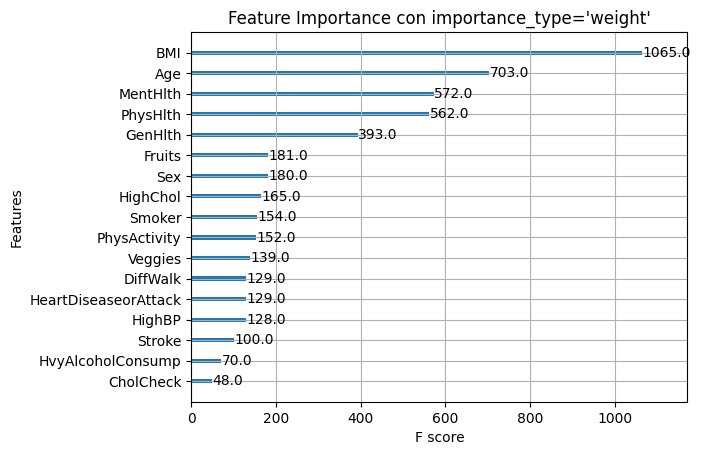

In [15]:
xgb.plot_importance(clf)
plt.title("Feature Importance con importance_type='weight'")
plt.show()

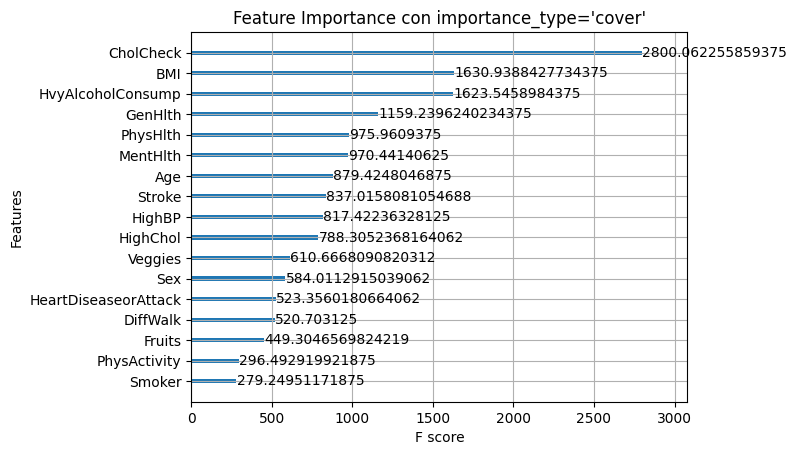

In [16]:
xgb.plot_importance(clf, importance_type="cover")
plt.title("Feature Importance con importance_type='cover'")
plt.show()

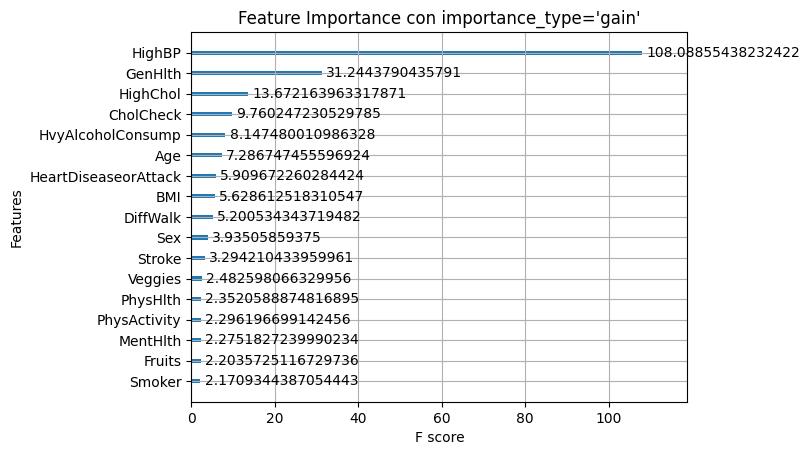

In [17]:
xgb.plot_importance(clf, importance_type="gain")
plt.title("Feature Importance con importance_type='gain'")
plt.show()

Como se puede observar, los gráficos obtenidos son muy diferentes al cambiar el tipo de importancia. Se puede observar que BMI y PhysHlth tienen un alto F-Score al usar los parámetros 'weight' y 'cover'. Esto quiere decir respectivamente que se utilizan numerosas veces cuando el modelo divide los datos a lo largo de los árboles de decisión, y también significa que estas características están presentes en muchos más nodos del árbol que el resto y tienen una mayor influencia en la toma de decisiones del modelo. \
Por otro lado, HighBP es la característica con mayor F-Score al usar la importancia 'gain'. De hecho, tiene un valor cuatro veces mayor al segundo feature que es GenHlth. Esto indica que HighBP contribuye mucho más a la reducción de la función de pérdida durante el entrenamiento que el resto de características.

Aunque estos gráficos proporcionan las características más importantes del modelo según el tipo de importancia utilizado, debido a las diferencias significativas entre los resultados, este método no es suficiente para establecer un orden de importancia claro entre ellas. Sin mencionar que este método puede inducir a errores en el caso de características con muchos valores posibles, ya que estas características pueden utilizarse con más frecuencia simplemente porque hay más oportunidades de dividirlas.

## 4. Métodos Agnósticos Globales (1 pt)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


1) ¿Cómo mide la importancia de las features su propuesta?\
2) ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?\
3) ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?\
4) Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [18]:
result = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)
result

{'importances_mean': array([ 0.02688765,  0.00108607,  0.01033887,  0.00339809,  0.03027002,
         0.00044009,  0.00265466,  0.00030177,  0.00029391,  0.0002389 ,
         0.00314032,  0.05647869, -0.00015403,  0.00215013,  0.00306802,
         0.00090375,  0.01651107]),
 'importances_std': array([0.00178451, 0.00069036, 0.00156143, 0.00052688, 0.00197189,
        0.00049533, 0.00053362, 0.00062892, 0.00066099, 0.00063178,
        0.00056525, 0.00222434, 0.0009654 , 0.00080044, 0.00072976,
        0.00044301, 0.00118245]),
 'importances': array([[ 2.71595624e-02,  2.79139947e-02,  2.85741230e-02,
          2.88098831e-02,  2.24915126e-02,  2.53206337e-02,
          2.51320257e-02,  2.69709544e-02,  2.38117691e-02,
          2.59336100e-02,  2.78196907e-02,  2.70652584e-02,
          2.81497548e-02,  2.76782346e-02,  2.68766503e-02,
          2.51320257e-02,  2.23972086e-02,  2.83383629e-02,
          2.84798189e-02,  2.92342512e-02,  2.69238023e-02,
          2.87155790e-02,  2.8432

In [19]:
#Desviacion estandar de cada feature
result.importances_std

array([0.00178451, 0.00069036, 0.00156143, 0.00052688, 0.00197189,
       0.00049533, 0.00053362, 0.00062892, 0.00066099, 0.00063178,
       0.00056525, 0.00222434, 0.0009654 , 0.00080044, 0.00072976,
       0.00044301, 0.00118245])

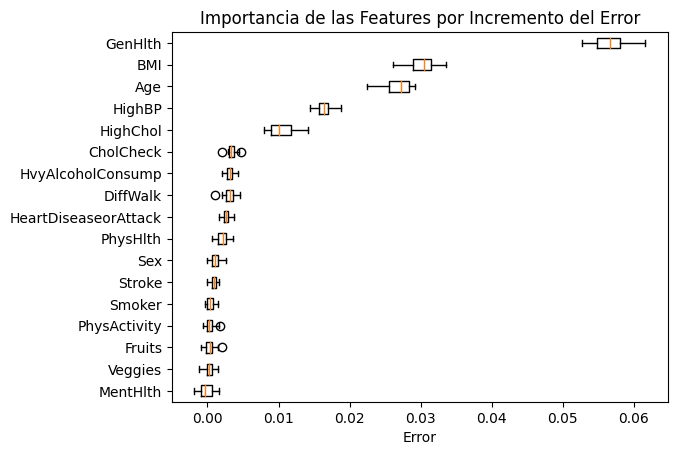

In [20]:
perm_sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=np.array(df.drop(columns=['Diabetes']).columns)[perm_sorted_idx], #Revisar
)
plt.title("Importancia de las Features por Incremento del Error")
plt.xlabel('Error')
plt.show()

**1)** La importancia de las features se determina al medir cómo afecta su permutación al rendimiento del modelo. Si permutar una característica en el conjunto de test causa una disminución significativa en el rendimiento del modelo, se considera que la característica es importante.

**2)** Como se puede observar en el gráfico obtenido, las carácteristicas que tienen más impacto en la salida del modelo son GenHlth, BMI, Age, HighBP y HighChol. Lo cuál tiene sentido, pues estás vairables representan los índices de masa del cuerpo, los niveles de colesterol y presión, junto a la edad del paciente.

**3)** Los resultados obtenidos son coherentes con la importancia de las características obtenidas con $\texttt{xgb.plot_importance()}$, salvo por la columna HighBP, ya que esta no obtuvo un F-Score tan alto en comparación con las otras cuatro columnas mencionadas.

**4)** Las ventaha de este método son que permite una fácil interpretación, una alta compresión de interpretabilidad global, y además no es necesario re-entrenar el modelo.\
Las desventajas serían que este método esta ligado los errores que pueda tener el modelo, por lo que depende mucho de la robustes de este. También puede generar sesgos por entradas atípicas que se pueden generar por la permutación, en especial cuando las features están muy correlacionadas entre sí. Por último, añadir una feature correlacionada puede decrecer la importancia de una feature asociada, dividiendo así la importancia entre ambas características

## 5. Métodos Agnósticos Locales (2 pt)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### Parte A (0.4 pt)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [21]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [22]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X)

In [23]:
shap_values

.values =
array([[-0.0410842 , -0.10157398, -0.43428537, ..., -0.04555928,
         0.00931672,  0.67858016],
       [ 0.01828577, -0.14552651,  0.18904144, ...,  0.02909943,
        -0.06048749,  0.44396472],
       [ 0.32893205, -0.1125998 , -0.0461641 , ..., -0.08024369,
         0.02551373, -0.7712385 ],
       ...,
       [ 0.31570172,  0.02914794,  0.42175272, ..., -0.02653435,
        -0.02536895,  0.27475402],
       [-0.0121767 ,  0.01036744,  0.29652175, ..., -0.02593282,
        -0.01086925,  0.5290728 ],
       [-0.13286543,  0.15055649,  0.2271811 , ..., -0.02066308,
        -0.02130302,  0.40102375]], dtype=float32)

.base_values =
array([-0.00838083, -0.00838083, -0.00838083, ..., -0.00838083,
       -0.00838083, -0.00838083], dtype=float32)

.data =
array([[ 4.,  1.,  0., ...,  0.,  0.,  1.],
       [12.,  1.,  1., ...,  0.,  1.,  1.],
       [13.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [13.,  0.,  1., ...,  1.,  0.,  1.],
       [11.,  0.,  1., ...,  1.,  0.

Los Shap values representan la contribución de cada característica a la predicción realizada por el modelo de XGBoost. Un valor positivo indica que la presencia de la característica asociada aumenta la probabilidad de que el modelo prediga que el paciente tiene diabetes. Por otro lado, un valor negativo significa que la ausencia de la característica o un valor bajo de esta disminuye la probabilidad de que el modelo determine que la persona tiene diabetes

### Parte B (0.4 pt)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:\
1.- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?\
2.- ¿Existe algún patrón común entre las instancias analizadas?\
3.- ¿Es posible generalizar estas conclusiones a todo el dataset?

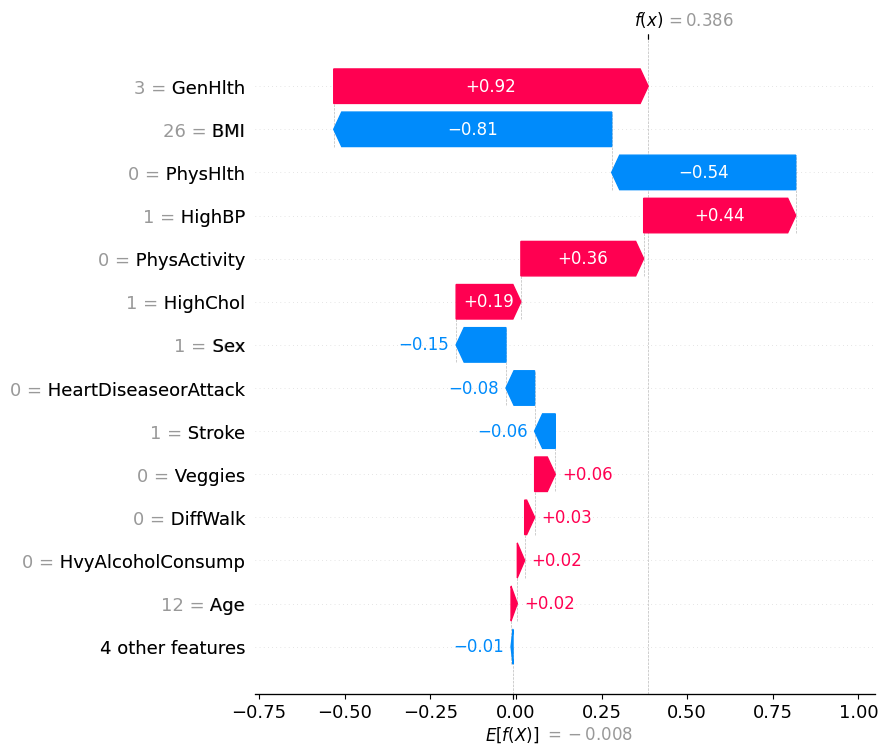

In [25]:
idx=1
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

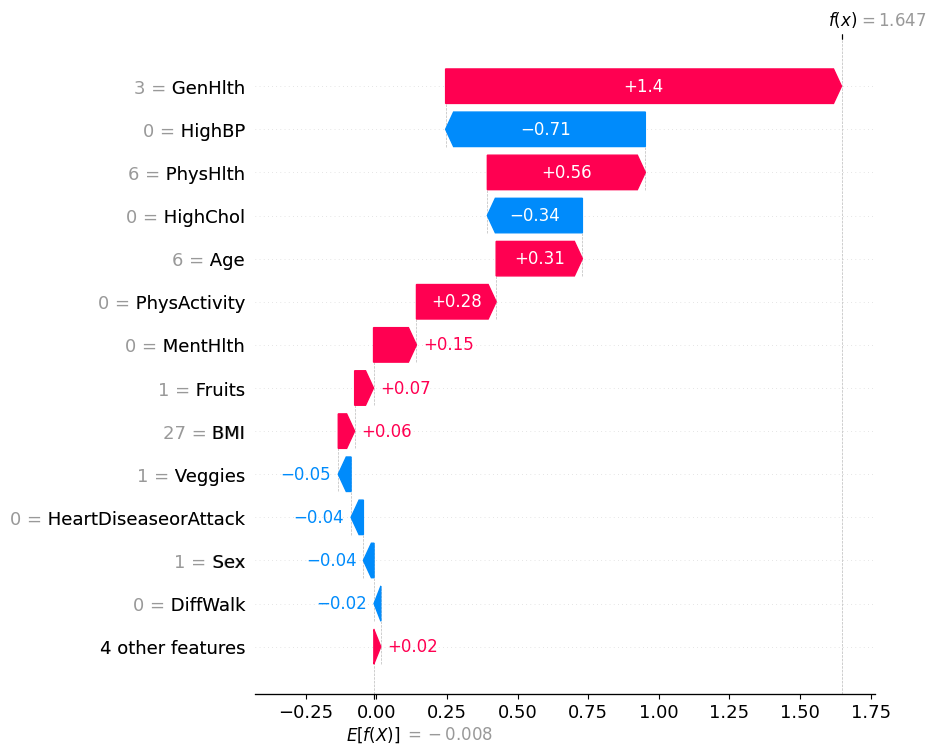

In [26]:
idx=9
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

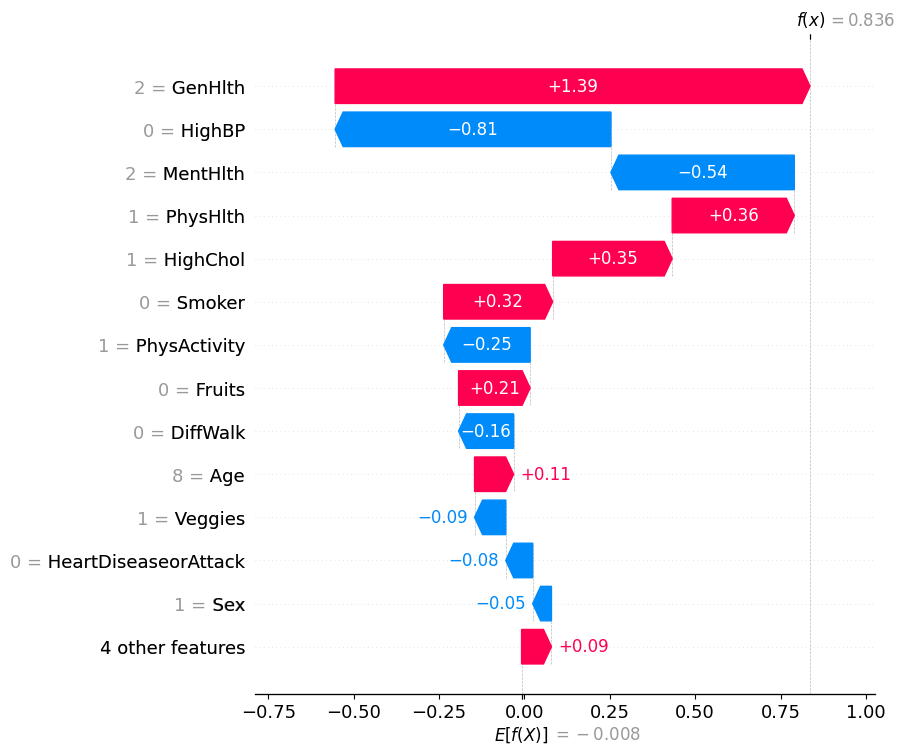

In [27]:
idx=25
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

1) La variable GenHlth afecta de manera positiva a la probabilidad de que un paciente sea diagnosticado con diabetes. Por otro lado, las variables HighChol, PhysHlth y HighBP también aportan una gran importancia a la decisión tomada por el modelo, no obstante la forma en que afectan a la probabilidad de ser diagnosticado por diabetes varía de persona en persona, por ejemplo, para la el paciente 1, HighCol tiene un valor shap positivo, mientras que en el paciente 9, el valor es negativo.

2) Para las 3 instancias estudiadas, se puede observar que las características Age y GenHlth poseen shap values positivos, mientras que las variable HeartDiseaseorAttack contribuye negativamente a la probabilidad de predicción de ser diagnosticado con diabetes.

3) Si bien, hay algunos patrones que se presentan en las tres instancias estudiadas, la importancia de la mayoría de las características varía mucho entre paciente. Por lo que se recomienda explorar otras técnicas de interpretación y análisis para obtener una comprensión más global de las características importantes en la clasificación de la diabetes.

### Parte C (0.4 pt)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

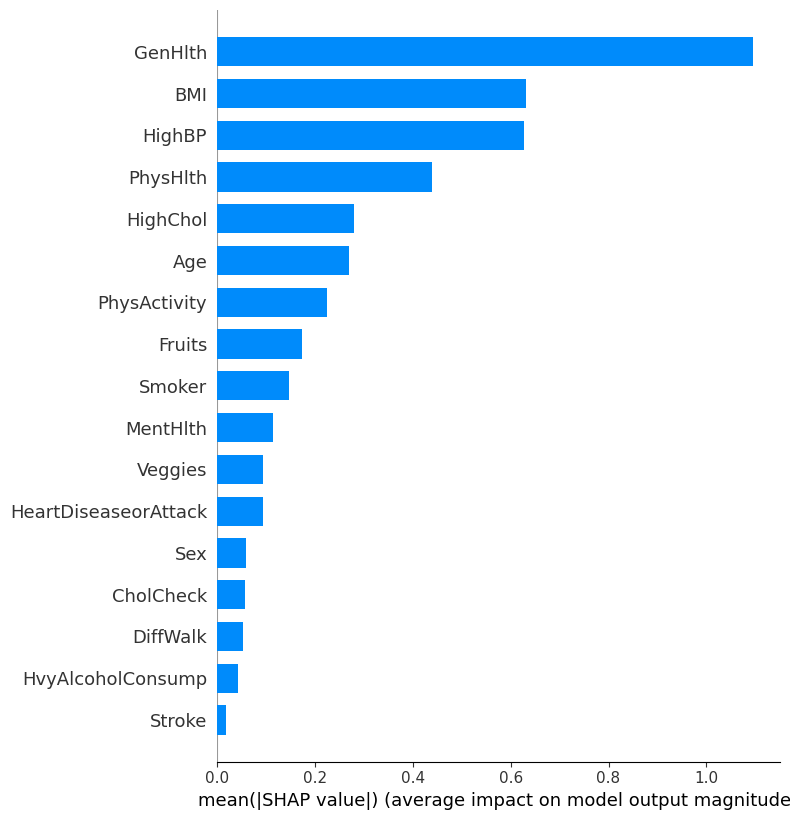

In [28]:
shap.summary_plot(shap_values, X, plot_type="bar")

Este gráfico corresponde al promedio del valor absoluto de los valores Shap en cada variable. De aquí se puede observar las características que tienen un imapcto más significativo en la predicción del modelo. Entre esta están las variables GenHlth, BMI, HighBP, PhysHlth y HighCol, lac cuáles fueron mencionadas en el análisis anterior al estudiar cada instancia por separado.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


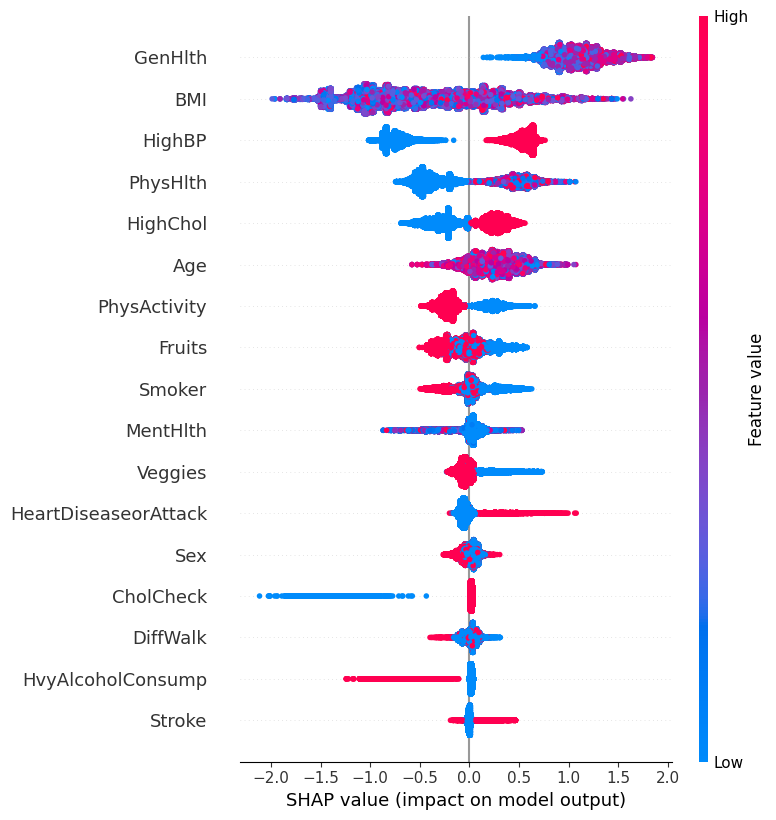

In [29]:
shap.summary_plot(shap_values, X)

En este otro gráfico, se muestra la distribución de los valores Shap para cada característica. Se puede observar que las variables "HighBP" y "HighCol", cuando tienen valores bajos, contribuyen a que el modelo prediga que el paciente no tiene diabetes. Sin embargo, cuando estas variables toman valores altos, aumenta la probabilidad de que el modelo clasifique a la persona como diabética.

Por otro lado, se puede notar que para la característica más importante,"GenHlth", sin importar el valor que tome el modelo tiende a diagnosticar a la persona con diabetes.

Sin embargo, la influencia de la segunda característica, "BMI", no es tan clara. Los valores de esta variable son muy diferentes para cada instancia y también cambian en términos de cómo contribuyen a la predicción del modelo.

### Parte D (0.4 pt)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [30]:
# obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

# Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = X_train.columns[shap_values_abs.argsort()[::-1]]

# Revisamos las features
feature_importance_names

Index(['GenHlth', 'BMI', 'HighBP', 'PhysHlth', 'HighChol', 'Age',
       'PhysActivity', 'Fruits', 'Smoker', 'MentHlth', 'Veggies',
       'HeartDiseaseorAttack', 'Sex', 'CholCheck', 'DiffWalk',
       'HvyAlcoholConsump', 'Stroke'],
      dtype='object')

In [31]:
y_pred_proba = clf.predict_proba(X)[:, 1]

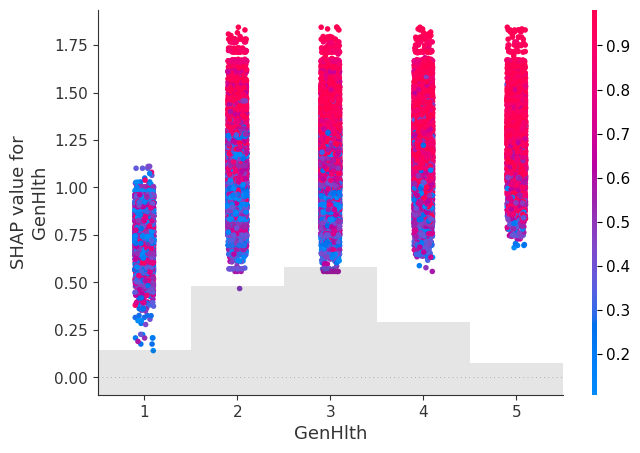

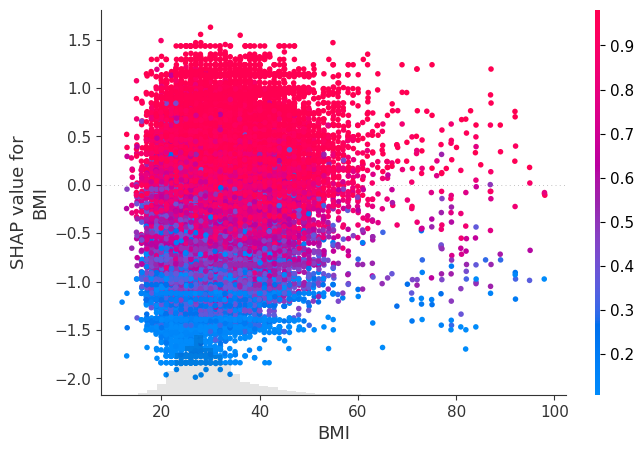

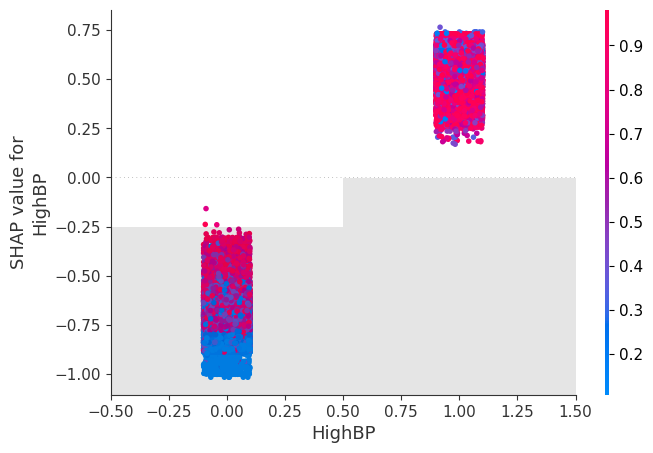

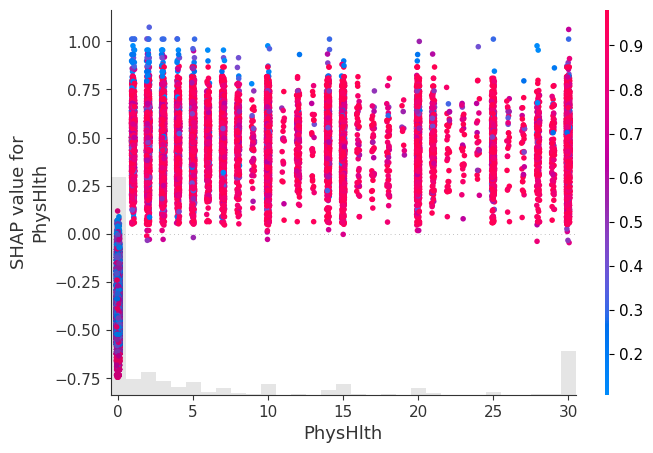

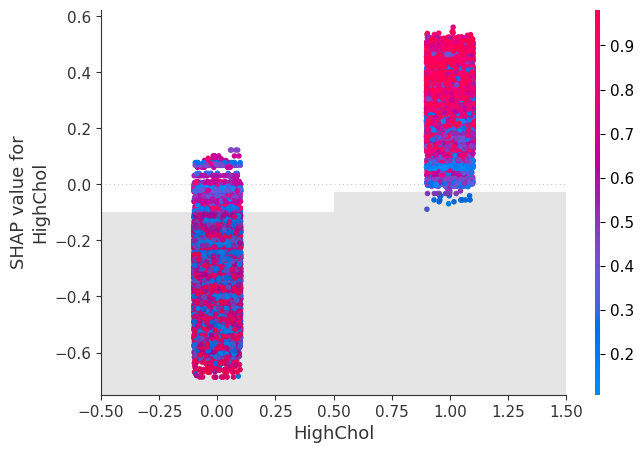

In [32]:
for name in feature_importance_names[:5]:
  shap.plots.scatter(shap_values[:,name], color=y_pred_proba) #shap_values)

Al colorear por la probabilidad de tener diabetes, se puede observar lo siguiente:\
-Para GenHlth (feature con mayor impacto global) se observa que a medida que aumenta su valor, también aumenta la probabilidad de ser diagnosticado con diabetes. \
-Para BMI, se puede observar que en las intancias que presentan un valor shap más alto, también es más probable de que el paciente sea diagnosticado diabético. \
-En el caso de PhysHlth, se tiene que el modelo clasificara al paciente como diabético para la gran mayoría de valores que tome esta variable. \
-Por último para HighBP y HighCol, se obtuvo que cuando estas variables son 0, no contribuyen significativamente a la predicción del modelo. Mientras que cuando son 1, la mayoría de las instancias serán clasificadas como diabéticas por el modelo.  

### Parte E (0.4 pt)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

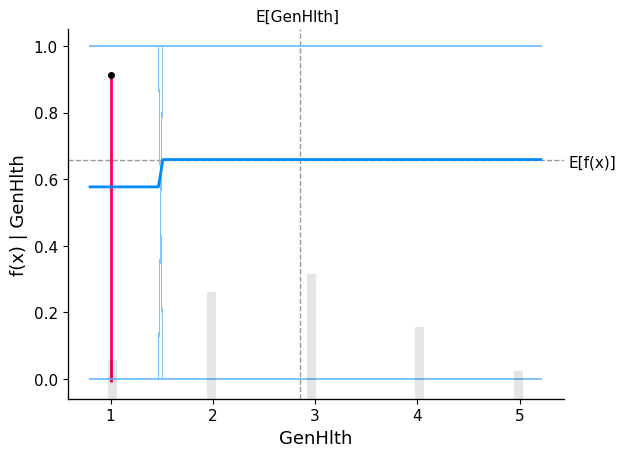

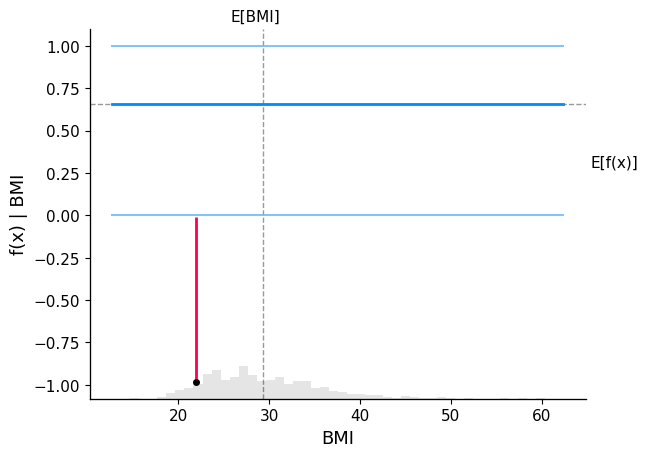

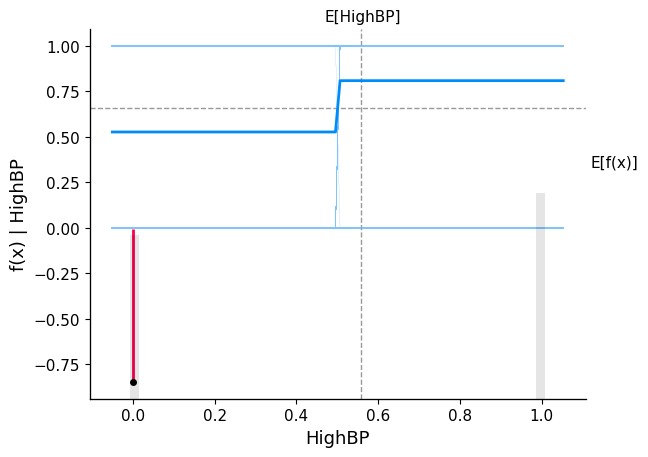

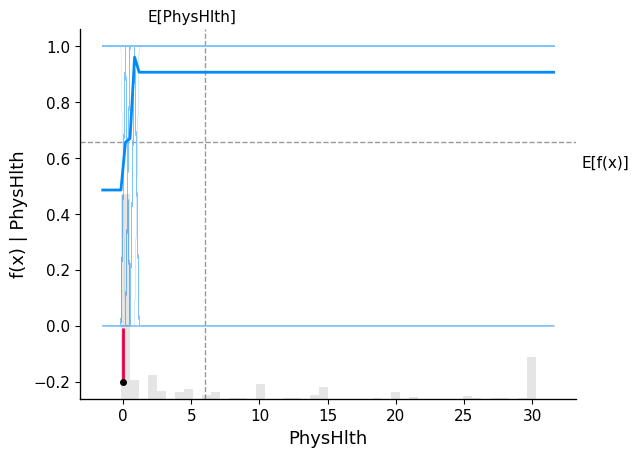

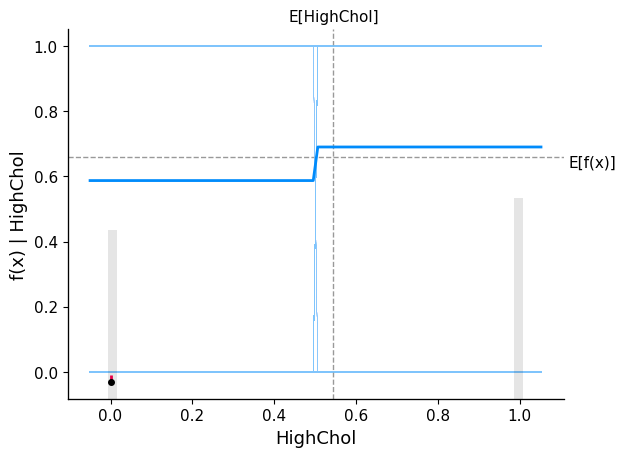

In [33]:
for name in feature_importance_names[:5]:
  X1000 = shap.utils.sample(X, 1000, random_state=42)
  sample_ind = 20
  shap.partial_dependence_plot(
      name, clf.predict, X1000, model_expected_value=True,
      feature_expected_value=True, ice=True,
      shap_values=shap_values[sample_ind:sample_ind+1,:]
)

A partir de los gráficos anteriores, se puede observar que el valor de predicción del modelo se mantiene prácticamente constante para las 5 características con mayor impacto global, con pequeñas variaciones que ocurren en intervalos específicos. Es interesante destacar que la variable PhysHlth muestra un cambio más significativo en f(x). Para valores bajos, se observa un comportamiento lineal en los valores de predicción, pero a medida que los valores aumentan, la predicción se estabiliza y se vuelve constante.

Aunque el gráfico de dependencia parcial es una herramienta útil para comprender la relación entre una característica y la salida del modelo, no logra capturar todas las posibles interacciones y dependencias entre las características, ni proporciona una descripción completa de la relación para cada instancia individual. Por lo tanto, es necesario complementar estos gráficos con otros análisis para obtener conclusiones generalizadas que sean aplicables a todo el conjunto de datos.

## 6. Sistema de Reglas! (1 pt)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [34]:
from alibi.explainers import AnchorTabular

In [35]:
predict_fn = lambda x: clf.predict(x)
explainer = AnchorTabular(predict_fn, clf.feature_names_in_, seed=1)
explainer.fit(X_train.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': 1, 'disc_perc': (25, 50, 75)},
  'version': '0.9.4'}
)

In [36]:
idxs=[1000, 3001, 5751]
class_names = ["No Diabetico", "Diabetico"]

for id in idxs:
  # Genera explicaciones
  explanation = explainer.explain(X_test.to_numpy()[id], threshold=0.95)

  # Accede a los atributos de explicación
  print(f'Sistema de reglas para el id = {id}')
  print('Prediction: ', class_names[explainer.predictor(X_test.to_numpy()[id].reshape(1, -1))[0]])
  print('Anchor: %s' % (' AND '.join(explanation.anchor)))
  print('Precision: %.2f' % explanation.precision)
  print('Coverage: %.2f' % explanation.coverage)
  print(' ')

Sistema de reglas para el id = 1000
Prediction:  No Diabetico
Anchor: PhysHlth <= 0.00 AND HighBP <= 0.00 AND PhysActivity > 0.00 AND HighChol <= 0.00 AND BMI <= 29.00 AND Sex > 0.00
Precision: 0.96
Coverage: 0.05
 
Sistema de reglas para el id = 3001
Prediction:  No Diabetico
Anchor: PhysHlth <= 0.00 AND HighBP <= 0.00 AND HighChol <= 0.00 AND PhysActivity > 0.00 AND Fruits > 0.00
Precision: 0.97
Coverage: 0.11
 
Sistema de reglas para el id = 5751
Prediction:  Diabetico
Anchor: PhysHlth > 5.00 AND HighBP > 0.00
Precision: 1.00
Coverage: 0.18
 


1) Para la observación 1000, se determinó con una precisión del 96% que el paciente no será clasificado como diabético. Esto es coherente ya que el sistema de reglas indica que esta persona no presenta una alta presión sanguínea (HighBP), ni niveles altos de colesterol (HighCol), y su índice de masa corporal (BMI) se encuentra en rangos aceptables. Sin embargo, el coverage para esta instancia es del 5%, lo que indica que estas reglas no se aplican de manera generalizada a todo el conjunto de datos.

2) Para la observación 3001, se concluyó con una precisión del 97% que el paciente no será clasificado como diabético, lo cual también es coherente. Al igual que en el caso anterior, no presenta una alta presión sanguínea ni niveles altos de colesterol. Además, parece ser una persona saludable, ya que realiza actividad física y se alimenta con frutas. El coverage en este caso es del 11%, lo que significa que esta explicación es válida para aproximadamente una décima parte de las instancias similares en el conjunto de datos.

3) Para la observación 5751, se clasificó al paciente como diabético. El sistema de reglas indica que esta persona puede tener hipertensión. La precisión es del 100% y el coverage es del 18%, que si bien no es muy alto, esta explicación representa a más casos que las observaciones anteriores.

# Retrospectiva... (1 pt)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

**Respuesta:** \
Después de realizar los análisis correspondientes, considero que en este caso resultan más útiles los métodos agnósticos locales. Dado que estamos tratando con un tema relacionado con la salud, es fundamental tener precaución no solo con el rendimiento del modelo, sino también con las conclusiones que se pueden extraer a partir de él. Si nos limitáramos a un análisis global, estaríamos reduciendo la interpretación a solo unas pocas variables, y es probable que los médicos ya tuvieran conocimiento de cuáles variables se correlacionan más con el diagnóstico de diabetes.

Sin embargo, mediante el uso de los shap values, podemos estudiar el impacto de la predicción del modelo caso por caso. Esto nos brinda información valiosa sobre cómo ciertas variaciones en características específicas influyen en la respuesta final del modelo. Esta información podría resultar muy útil para el personal médico, ya que les permitiría identificar patrones que revelen si un paciente es diabético o no. De esta manera, podrían realizar un diagnóstico a tiempo e iniciar un tratamiento adecuado. Es importante considerar que este enfoque más detallado puede proporcionar una visión más completa y precisa de cada caso individual, mejorando así la toma de decisiones en el ámbito de la salud.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>